# `CNRatioModel` Tutorial

Trey V. Wenger (c) December 2024

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{13}{\rm C}/^{12}{\rm C}$. The model is similar to `CNModel`, with the following assumptions and limitations:

1. Hyperfine anomalies are only predicted for ${\rm CN}$. We assume that $^{13}{\rm CN}$ does not suffer from hyperfine anomalies.
2. We assume that the cloud mean ${\rm CN}$ excitation temperature is equal to the cloud mean $^{13}{\rm CN}$ excitation temperature.
3. The ratio parameter `log10_13C_12C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{\rm tot, $13CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$, which we assume is the same ratio over *all* states.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+4.g37a7161.dirty


## Simulate Data

12CN 300
13CN 250
Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 4 from lower state 0
Transition 113490.985 is constraining upper state 1 from lower state 0
Transition 113508.934 is constraining upper state 2 from lower state 0
Transition 113520.4215 is constraining upper state 3 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 6 from lower state 2
Transition 108636.923 is constraining upper state 8 from lower state 2
Transition 108651.297 is constraining upper state 0 from lower state 2
Transition 108986.8678 is constraining upper state 1 from lower state 2
Transition 109217.6017 is constraining upper state 4 from lower 

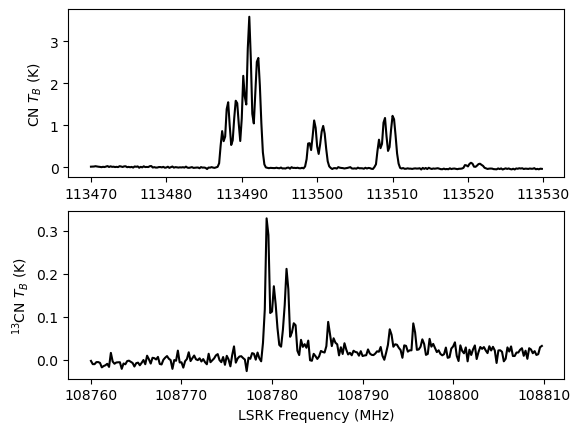

In [6]:
import astropy.constants as c
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise_12CN = 0.01 # K
noise_13CN = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN = noise_12CN * np.random.randn(len(freq_axis_12CN)) # K
brightness_data_13CN = noise_13CN * np.random.randn(len(freq_axis_13CN)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    brightness_data_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    brightness_data_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {"12CN": observation_12CN, "13CN": observation_13CN}
for label, dataset in dummy_data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [12.5, 0.1], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.0, 0.1], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tex = [1.75, 0.25], # mean and width of log10 cloud mean excitation temperature prior (K)
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_12CN_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

# here we specify the normalized log boltzmann factor offset for simplicity
log_boltz_factor_12CN_free_norm = np.zeros((len(model.model.coords["transition_free_12CN"]), n_clouds))
log_boltz_factor_12CN_free_norm[3] = [-1.0, -0.25, -0.1]
log_boltz_factor_12CN_free_norm[4] = [2.0, 0.5, 0.3]

sim_params = {
    "log10_N0_12CN": [12.8, 12.6, 12.2],
    "log10_N0_13CN": [10.8, 11.0, 11.2],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "log10_Tex_mean": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [-2.0, -5.0, 8.0],
    "baseline_13CN_norm": [1.0, 3.0, -4.0],
    "log_boltz_factor_12CN_free_norm": log_boltz_factor_12CN_free_norm,
}
sim_12CN = model.model["12CN"].eval(sim_params, on_unused_input="ignore")
sim_13CN = model.model["13CN"].eval(sim_params, on_unused_input="ignore")
tau_total_12CN = model.model.tau_total_12CN.eval(sim_params, on_unused_input="ignore")
tau_total_13CN = model.model.tau_total_13CN.eval(sim_params, on_unused_input="ignore")
log10_N_12CN = model.model.log10_N_12CN.eval(sim_params, on_unused_input="ignore")
log10_N_13CN = model.model.log10_N_13CN.eval(sim_params, on_unused_input="ignore")
log10_13C_12C_ratio = model.model.log10_13C_12C_ratio.eval(sim_params, on_unused_input="ignore")

derived_params = {
    "log10_N_12CN": log10_N_12CN,
    "tau_total_12CN": tau_total_12CN,
    "log10_N_13CN": log10_N_13CN,
    "tau_total_13CN": tau_total_13CN,
    "log10_13C_12C_ratio": log10_13C_12C_ratio,
}

print()
print("tau_total:")
print(tau_total_12CN)
print(tau_total_13CN)

print()
print("log10_N:")
print(log10_N_12CN)
print(log10_N_13CN)

print()
print("log10_13C_12C_ratio")
print(log10_13C_12C_ratio)

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN"].spectral, sim_12CN, "k-")
axes[0].set_ylabel(dummy_data["12CN"].ylabel)
axes[1].plot(dummy_data["13CN"].spectral, sim_13CN, "k-")
axes[1].set_xlabel(dummy_data["13CN"].xlabel)
_ = axes[1].set_ylabel(dummy_data["13CN"].ylabel)

## Model Definition

In [11]:
# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN = SpecData(
    freq_axis_12CN,
    sim_12CN,
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN = SpecData(
    freq_axis_13CN,
    sim_13CN,
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {"12CN": observation_12CN, "13CN": observation_13CN}
for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0_12CN = [12.5, 0.1], # mean and width of log10 12CN ground state column density prior (cm-2)
    prior_log10_N0_13CN = [11.0, 0.1], # mean and width of log10 13CN ground state column density prior (cm-2)
    prior_log10_Tex = [1.75, 0.25], # mean and width of log10 cloud mean excitation temperature prior (K)
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_12CN_sigma = 0.1, # width of hyperfine anomaly prior
    fix_log10_Tkin = 1.75, # assume kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

12CN 300
13CN 250
Transition 113144.19 is constraining upper state 0 from lower state 0
Transition 113191.325 is constraining upper state 4 from lower state 0
Transition 113490.985 is constraining upper state 1 from lower state 0
Transition 113508.934 is constraining upper state 2 from lower state 0
Transition 113520.4215 is constraining upper state 3 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 0
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 108631.121 is constraining upper state 6 from lower state 2
Transition 108636.923 is constraining upper state 8 from lower state 2
Transition 108651.297 is constraining upper state 0 from lower state 2
Transition 108986.8678 is constraining upper state 1 from lower state 2
Transition 109217.6017 is constraining upper state 4 from lower 

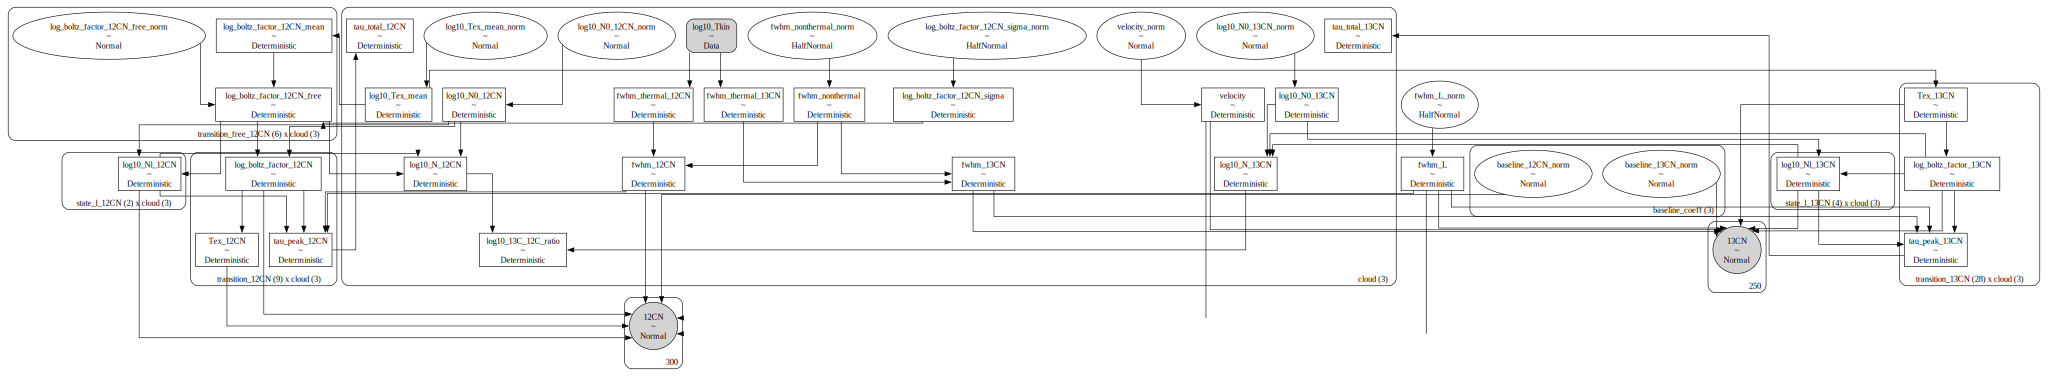

In [12]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [13]:
# model string representation
print(model.model.str_repr())

              baseline_12CN_norm ~ Normal(0, <constant>)
              baseline_13CN_norm ~ Normal(0, <constant>)
              log10_N0_12CN_norm ~ Normal(0, 1)
              log10_N0_13CN_norm ~ Normal(0, 1)
             log10_Tex_mean_norm ~ Normal(0, 1)
log_boltz_factor_12CN_sigma_norm ~ HalfNormal(0, 1)
 log_boltz_factor_12CN_free_norm ~ Normal(0, 1)
                   velocity_norm ~ Normal(0, 1)
            fwhm_nonthermal_norm ~ HalfNormal(0, 1)
                     fwhm_L_norm ~ HalfNormal(0, 1)
                   log10_N0_12CN ~ Deterministic(f(log10_N0_12CN_norm))
                   log10_N0_13CN ~ Deterministic(f(log10_N0_13CN_norm))
                  log10_Tex_mean ~ Deterministic(f(log10_Tex_mean_norm))
                        Tex_13CN ~ Deterministic(f(log10_Tex_mean_norm))
           log_boltz_factor_13CN ~ Deterministic(f(log10_Tex_mean_norm))
                   log10_Nl_13CN ~ Deterministic(f(log10_N0_13CN_norm, log10_Tex_mean_norm))
                    log10_N_13CN ~

Sampling: [12CN, 13CN, baseline_12CN_norm, baseline_13CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_12CN_norm, log10_N0_13CN_norm, log10_Tex_mean_norm, log_boltz_factor_12CN_free_norm, log_boltz_factor_12CN_sigma_norm, velocity_norm]


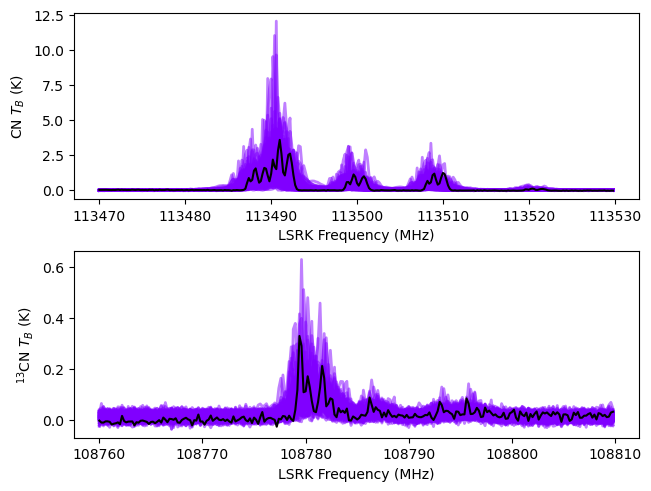

In [14]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

In [ ]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.1, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.03, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

In [12]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N0[0],11.806,0.004,11.799,11.814,0.000,0.000,911.0,912.0,NaN
log10_N0[1],12.181,0.002,12.177,12.185,0.000,0.000,921.0,874.0,NaN
log10_N0[2],12.341,0.001,12.339,12.344,0.000,0.000,891.0,975.0,NaN
log10_Tkin[0],1.839,0.043,1.764,1.919,0.001,0.001,1007.0,908.0,NaN
log10_Tkin[1],1.973,0.028,1.920,2.024,0.001,0.001,804.0,850.0,NaN
log10_Tkin[2],1.922,0.019,1.884,1.956,0.001,0.000,1089.0,918.0,NaN
log10_Tex_mean[0],1.839,0.043,1.764,1.919,0.001,0.001,1007.0,908.0,NaN
log10_Tex_mean[1],1.973,0.028,1.920,2.024,0.001,0.001,804.0,850.0,NaN
log10_Tex_mean[2],1.922,0.019,1.884,1.956,0.001,0.000,1089.0,918.0,NaN
log10_N[0],12.559,0.005,12.549,12.567,0.000,0.000,1102.0,847.0,NaN


Sampling: [observation]


Output()

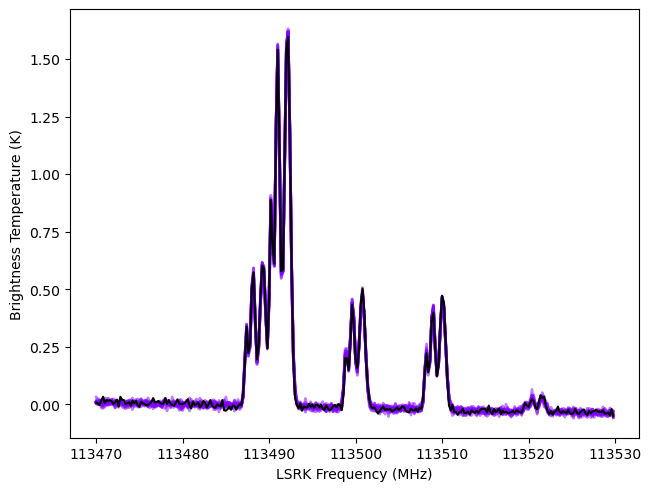

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.01}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 29,402
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

In [ ]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

In [ ]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_0.png")

In [ ]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

In [ ]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_2.png")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [ ]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

In [ ]:
print(sim_params)
print(derived_params)